#### setting up

In [7]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
from copy import deepcopy

# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import distributions as dst
# from sklearn.linear_model import LogisticRegression, LinearRegression

# Util Modules
from util.td_model import ThermodynamicModel
from util.data_functions import *
from util.model_functions import *
from util.general_functions import tally

# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [21]:
genome = SeqIO.read("../data/Ecoli/NC_000913.gbk", "genbank")

In [9]:
fttypes = set([ft.type for ft in genome.features])
genomeFlags = OrderedDict([])
take = OrderedDict([])
for fttype in fttypes:
    # print (fttype)
    take[fttype] = [ft for ft in genome.features if ft.type==fttype]
    nparts = [len(ft.location.parts) for ft in take[fttype]]
    # assert all parts within features are on the same strand
    for ft in take[fttype]:
        pts = ft.location.parts
        assert np.all([pt.strand==pts[0].strand for pt in pts])
    locs = [pt for ft in take[fttype] for pt in ft.location.parts]
    x = np.zeros((2,len(genome)))
    for il,lc in enumerate(locs):
        k = int(lc.strand<0)
        # assert lc.start == lc.nofuzzy_start
        # assert lc.end   == lc.nofuzzy_end
        x[k,lc.start:lc.end] = 1
    genomeFlags[fttype] = x


genFilter = OrderedDict([
    ################ intra-genic ################
    ("within", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        # "mobile_element",
                        # "repeat_region",
                        # "rep_origin",
                        # "tRNA",
                        # "STS",
                        # "tmRNA",
                        # "source"
                        # "rRNA",
                        # "ncRNA",
                        "CDS",
                        "gene",
                    ]]).sum(axis=0)>0),
    ################ inter-genic ################
    ("outside", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        "mobile_element",
                        "repeat_region",
                        # "rep_origin",
                        "tRNA",
                        "STS",
                        "tmRNA",
                        # "source"
                        "rRNA",
                        "CDS",
                        "gene",
                        "ncRNA",
                    ]]).sum(axis=0)==0),
    ])

In [12]:
numGen = np.array([lett2idx[l] for l in genome.seq.lower()],dtype=np.int8)

In [13]:
baseFrac = {}
for fl in genFilter:
    a = np.array(tally(numGen[genFilter[fl]], pandas=True))
    baseFrac[fl] = a/a.sum()

In [15]:
baseFrac

{'within': array([[0.00000000e+00, 2.41130207e-01],
        [2.40479709e-07, 2.59345583e-01],
        [4.80959418e-07, 2.58570276e-01],
        [7.21439127e-07, 2.40952492e-01]]),
 'outside': array([[0.00000000e+00, 2.95089304e-01],
        [2.23762704e-06, 2.04874894e-01],
        [4.47525408e-06, 2.06333827e-01],
        [6.71288112e-06, 2.93688549e-01]])}

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

In [16]:
with open("../models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    theModel = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
# treat sequences as if they come from 36N library
# (essentially, only affects which chemical potential is used)
treatAs = "36N"

In [18]:
# we are not interested to model how rc binding interferes with frw.
# but are using the rc strand as an independent strand.
# so, we can turn off the rc flag in the model
theModel["includeRC"] = False

In [19]:
genOffset = sum(theModel["Layout"]) + theModel["spFlex"] # depends on the Layout and spFlex
numSeqs = np.array([
    np.hstack([numGen[-genOffset:],numGen      ]),
  3-np.hstack([numGen      ,numGen[: genOffset]])[::-1],
    
], dtype=np.int8)

assert np.all(numSeqs>=0)

In [20]:
bricks = getBrickDict({treatAs: numSeqs}, theModel)[treatAs]
freeEs = -logsumexp(-bricks, axis=-1)

In [20]:
FreeEnergy = { fl: freeEs[:,genFilter[fl]].flatten() for fl in genFilter }

In [23]:
# %%time  # 1h 10mins
# NrndGenome = int(1e8)

# rndFreeEs = OrderedDict()
# for fl in baseFrac:
#     np.random.seed(0)
#     rndGenome = np.random.choice(range(4), size=NrndGenome, p=baseFrac[fl])
#     rndSeq = np.array([
#             np.hstack([rndGenome[-genOffset:],rndGenome      ]),
#           3-np.hstack([rndGenome,rndGenome[: genOffset]])[::-1],
#         ], dtype=np.int8)
#     bricks = getBrickDict({treatAs: rndSeq}, theModel)[treatAs]
#     rndFreeEs[fl] = -logsumexp(-bricks, axis=-1).flatten()

In [21]:
{fl:rndFreeEs[fl].size/FreeEnergy[fl].size for fl in genFilter}

NameError: name 'rndFreeEs' is not defined

In [124]:
# with open("nbdumps/random_genome_free_energies.dmp","wb") as f:
#     pickle.dump(rndFreeEs,f)

In [22]:
with open("../nbdumps/random_genome_free_energies.dmp","rb") as f:
    rndFreeEs = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'nbdumps/random_genome_free_energies.dmp'

In [23]:
db = .2
bbs = np.arange(freeEs.min()-1, freeEs.min()+20, db)
bbs -= db/2

In [24]:
binCenters = (bbs[:-1]+bbs[1:])/2

In [25]:
rndCdf = {fl: [(rndFreeEs[fl]<l).sum()/rndFreeEs[fl].size for l in bbs[1:]] for fl in genFilter}

NameError: name 'rndFreeEs' is not defined

In [26]:
realCumulHist = {fl: np.array([(FreeEnergy[fl]<l).sum() for l in bbs[1:]]) for fl in genFilter}

In [27]:
rndCumulHist = {fl: np.array(rndCdf[fl])*FreeEnergy[fl].size for fl in genFilter}

NameError: name 'rndCdf' is not defined

In [28]:
offset = freeEs.min()

In [29]:
x = binCenters-offset

In [31]:
CI = .95

NameError: name 'rndCumulHist' is not defined

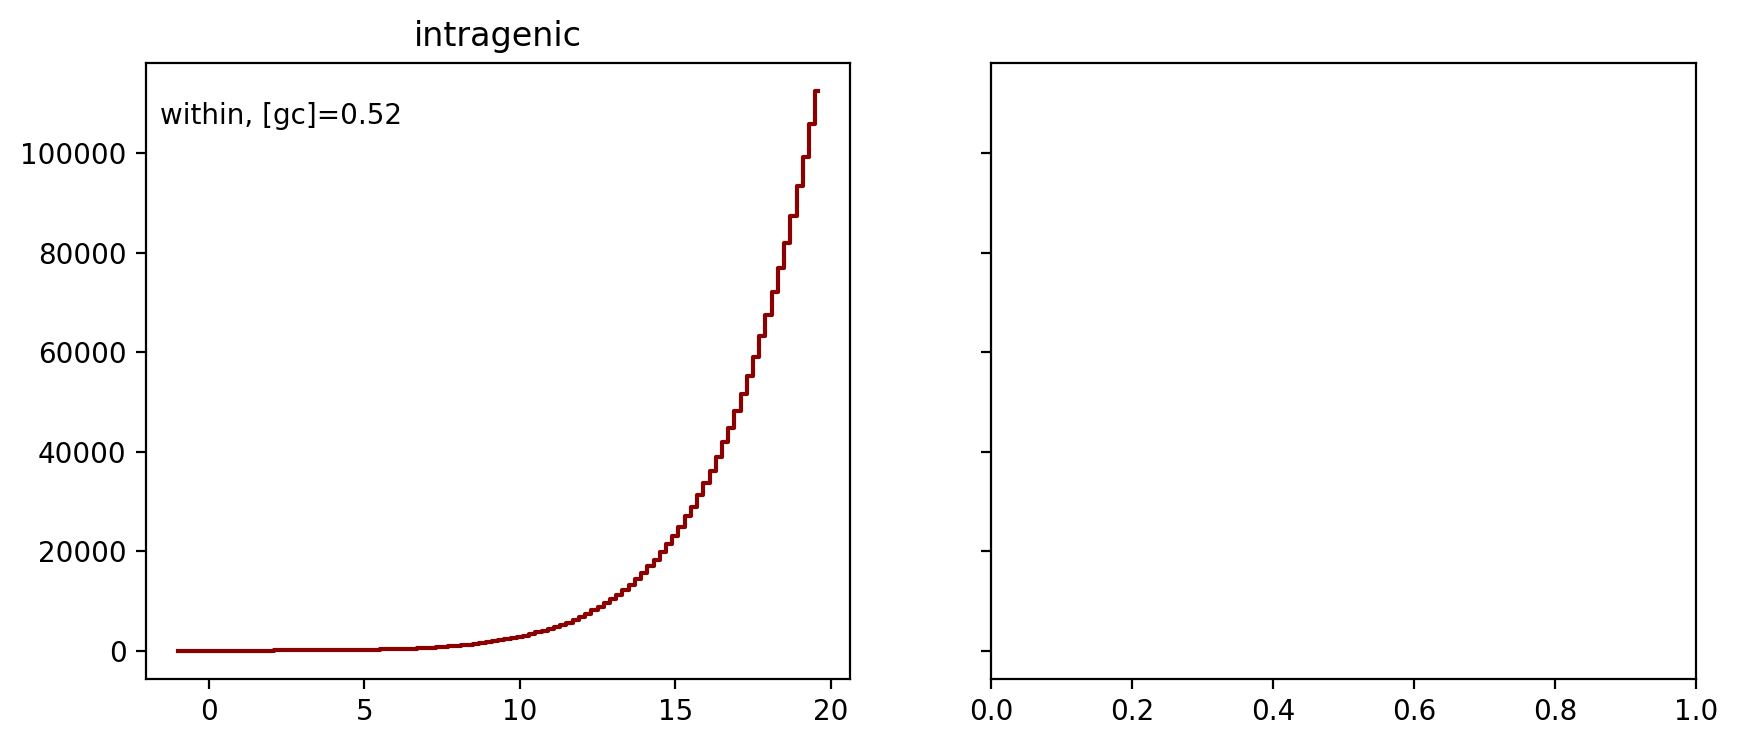

In [32]:
fig, axs = plt.subplots(1,2,figsize=(10,4), sharey=True)
for ax,fl in zip(axs, genFilter):
    ax.text(.02,.9, f"{fl}, [gc]={baseFrac[fl][1:3].sum():.2f}", transform=ax.transAxes)
    ax.set_title("intergenic" if fl=="outside" else "intragenic")
    ax.step(x, realCumulHist[fl], where="mid", color="darkred")
#     ax.step(x, rndCumulHist[fl], where="mid")
    ax.plot(x, rndCumulHist[fl], color="k")
#     ax.plot(x, )
    
    
    ax.fill_between(x,
                    dst.poisson.ppf(1-(1-CI)/2,mu=rndCumulHist[fl]),
                    dst.poisson.ppf((1-CI)/2,mu=rndCumulHist[fl]), 
                    color="lightgrey"
                   )
    ax.set_yscale("log")
    ax.set_xlim(-.1,)
plt.ylim(.3,)

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\D'
C:\Users\drago\AppData\Local\Temp\ipykernel_34956\1115275757.py:52: SyntaxWarning: invalid escape sequence '\l'
  axs[0,0].set_ylabel("number of bindings $\leq \Delta E$")
C:\Users\drago\AppData\Local\Temp\ipykernel_34956\1115275757.py:55: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("b.s. free energy $\Delta E$")
C:\Users\drago\AppData\Local\Temp\ipykernel_34956\1115275757.py:52: SyntaxWarning: invalid escape sequence '\l'
  axs[0,0].set_ylabel("number of bindings $\leq \Delta E$")
C:\Users\drago\AppData\Local\Temp\ipykernel_34956\1115275757.py:55: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("b.s. free energy $\Delta E$")


NameError: name 'freeEbinCenters' is not defined

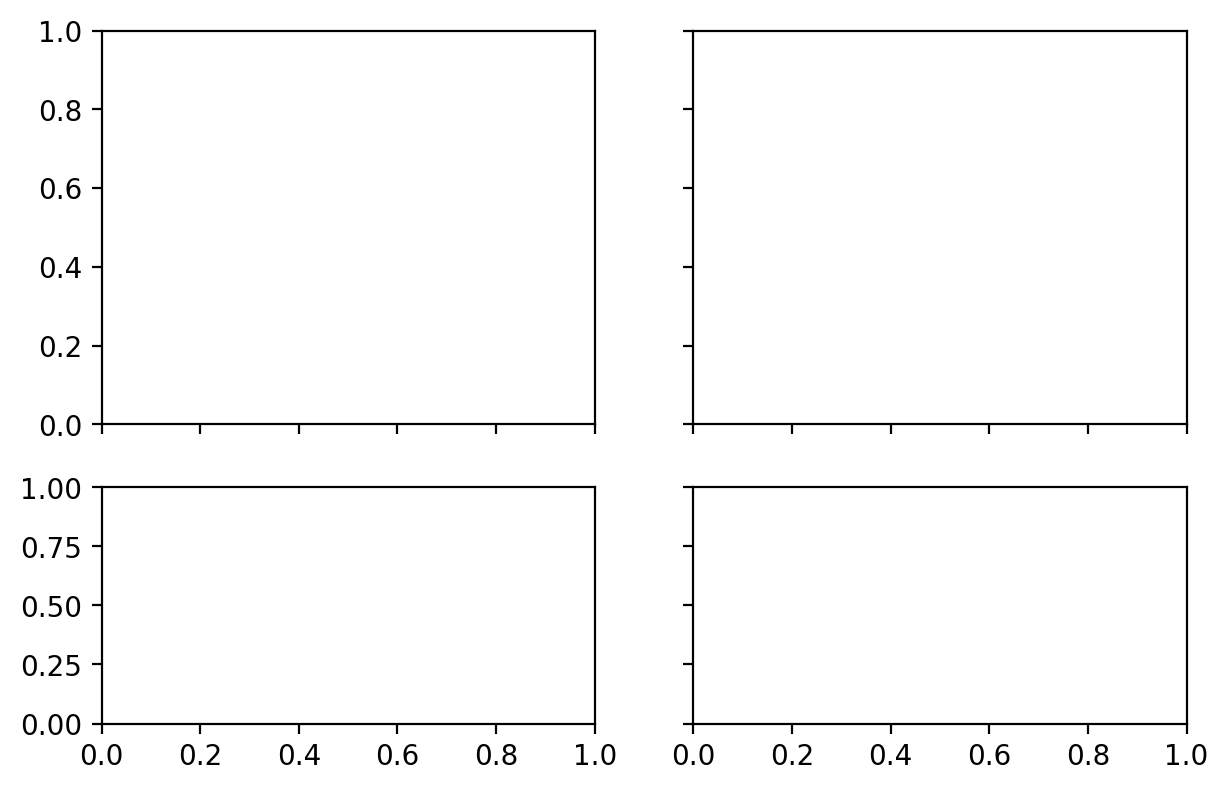

In [33]:
# full_dn panel with cumm p-value
NreBin = 1
Nsigma = 2
fig,axs = plt.subplots(2,2,figsize=(7,4.5), gridspec_kw={"height_ratios":[3,1.8]}, sharex=True, sharey="row")
fitID = 'full'#'full-CR-rc'
dinu = 1
x = freeEbinCenters[:len(freeEbinCenters)//NreBin*NreBin].reshape((-1,NreBin)).mean(1)
dx = x[1]-x[0]
ixmax = np.where(x>=freeE[fitID].min())[0][0]
xoffset = x[ixmax]
x = x-xoffset+dx/2
for axx,fl in zip([axs.T[0],axs.T[1]],["outside", "within"]):
    Yshow = pd.DataFrame({"x":x})
    for yht in ["YH", "YHreal"]:
        Yshow[("real" if "real" in yht else "rnd")] = eval(yht+"['"+fitID+"_"+fl+"_dn"*dinu+"']")
    for k in ["real","rnd"]:
        Yshow[k+"_p"] = np.cumsum(Yshow[k])/Yshow[k].sum()
        Yshow[k+"_p_err"] = (Yshow[k+"_p"]*(1-Yshow[k+"_p"])/Yshow[k].sum())**.5
    yexp = Yshow["rnd_p"]*Yshow["real"].sum()
    axx[0].set_title("intergenic" if fl=="outside" else "intragenic")
    axx[0].step(Yshow["x"],yexp.values,where="mid",c="k",
                    label=r"expected ($\pm %i\sigma$)"%Nsigma)
    axx[0].fill_between(
        np.array([Yshow["x"]-dx/2,Yshow["x"]+dx/2]).T.flatten(),
        np.array([yexp.values+Nsigma*yexp**.5]*2).T.flatten(),
        np.array([yexp.values-Nsigma*yexp**.5]*2).T.flatten(),
        alpha = .3,color="grey"
                       )
    axx[0].step(Yshow["x"],np.cumsum(Yshow["real"]),where="mid",c="darkred",label="observed")
    yexpErr = yexp**.5
    zscore = (np.cumsum(Yshow["real"])-yexp)/yexpErr
    log10pvs = np.maximum(dst.norm.logcdf(zscore)/np.log(10),-1000)
    axx[1].step(Yshow["x"],log10pvs,where="mid",color=c)
    for resc in [1]:
        tmp = Yshow.query("x>%f"%((measurableFreeE-xoffset)*resc)).iloc[0]
        twoNS = np.log(tmp["real_p"]/tmp["rnd_p"])
        twoNSerr = np.sqrt(tmp["real_p_err"]**2/tmp["real_p"]**2 + tmp["rnd_p_err"]**2/tmp["rnd_p"]**2)
        twoNSz = twoNS/twoNSerr
        pv = np.maximum(dst.norm.logcdf(twoNSz)/np.log(10),-100)
        print ("%20s \t %.5f %.5f %3.1e"%(fl, twoNS, twoNSerr,10**pv))
    print ('='*30)

for ax in axs.flat: ax.axvline(measurableFreeE-xoffset,color="grey",ls="--",lw=.7)
for ax in axs[0]:
    ax.set_yscale("log")
    ax.set_xlim(-.02,16)
    ax.set_ylim(.8,3e5)
for ax in axs[1]:
    ax.set_yscale("symlog")
    ax.set_ylim(-110,-.2)

axs[0,0].set_ylabel("number of bindings $\leq \Delta E$")
axs[0,0].legend(loc=4)
for ax in axs[1]:
    ax.set_xlabel("b.s. free energy $\Delta E$")
    ax.yaxis.set_minor_locator(MinorSymLogLocator(1))
    ax.grid(which="both",lw=.4,axis="y")
ax = plt.subplot(axs[1,0])
yt = list(plt.yticks()[0].astype(int))[:-1]
plt.yticks(yt,yt)
ax.set_ylabel(r"$\log _{10}$ p-value"+"\nfor "+r"$s<0$")
# ax.set_ylabel(r"$p$-value"+"\nfor "+r"$s<0$")
plt.subplots_adjust(hspace=0.01,wspace=0.1)
# fig.tight_layout()
# fig.savefig("figures/CDF_free_energy.pdf")
# fig.savefig("figures/CDF_free_energy.eps")